# Introduction

One way to classify chromatic noise is from the shape of its power spectral density (PSD). For example, we know that a white noise series should have a uniform/flat PSD and that pink noise is distributed according to 1/$f_{s}$ for some sampling frequency $f_{s}$.

This classification task is easy enough for a human to do. There have been many examples throughout these notebooks where a "reference line" is plotted against the PSD (or some other signal) and a human decided the signal follows the reference "close enough". 

The point of this notebook is to make the classification task more robust. We'll make use of least squares methods to determine the best fit curve. 

## Potential Issues

One problem with using a least squares method is that many of the algorithms require the degree of the curve as a parameter. Because of this requirement, it's clear that this is not exactly the solution to the problem. 

What we want is, given a power spectral density (PSD) plot/data (in linear or logarithmic scale), determine the degree *b* of the power law *PSD*(f)=a$f^{b}$ that is the best fit curve. 

---

An Important assumption is that *the best fit curve is truly a power law*. This assumption is justified according to the abundance of reference material on chromatic noise. 

In [1]:
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

In [2]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

# Making Noise

Previous notebooks in this project series also required noise series. In many cases, noise series generation was handled by packages from `AllanTools`. However, by writing our own noise generation code, the project will be more self contained.

Below, there are 2 methods `make_bias_drift` and `make_random_walk`. As their names imply, each method produces a different kind of chromatic noise. The underlying algorithms for doing so come from [K. Jerath](https://www.mathworks.com/matlabcentral/fileexchange/64590-allan-variance-analysis-of-simulated-sensor-noise)

In [3]:
def make_bias_drift(experiment_length, num_samples, tc=1000, initial_position=0):

    np.random.seed(seed=0)

    b = np.zeros(shape=(num_samples,))
    b[0] = initial_position

    for i in range(1, num_samples):
        bdot = (-1/tc)*b[i-1] + 0.01*np.random.randn(1)
        b[i] = b[i-1]+bdot
    
    time = np.linspace(0, experiment_length, num_samples)

    return (time, b)

In [4]:
def make_random_walk(experiment_length, num_steps, step_size=0.05, initial_position=0):

    np.random.seed(seed=1)

    time = np.linspace(0, experiment_length, num_steps+1)

    #keeping track of all positions throughout the walk
    walk = np.zeros((num_steps+1))

    position = initial_position
    #take steps
    for step in range(0, num_steps):
        #draw from uniform distribution [0,1)
        r = np.random.rand(1)

        if r<=0.5:
            #step down according to the step size
            position -= step_size
        else:
            #step up according to the step size
            position += step_size

        #update the walk
        walk[step+1] += position

    return (time, walk)

Since the PSD are functions of the sampling frequency, we fix the length of the simulation. Then, we can change the sampling rate by changing the number of samples collected in that time frame. Finally, the sampling rate is calculated in Hertz

In [5]:
#time scale of the simulated experiment seconds
experiment_length = 1
#number of samples collected in time `experiment_length`
#num_samples = 100
num_samples=1_000
#sampling rate (Hz)
fs = num_samples/experiment_length

In [6]:
fs

1000.0

## Pink Noise, Flicker Noise, Bias Instability

In [7]:
#pink noise series
pink_noise = make_bias_drift(experiment_length=experiment_length, num_samples=num_samples)

In [8]:
#estimate the PSD for a pink noise series using Welch algorithm
pink_freq, pink_psd = welch(pink_noise[1], fs=fs)

**NB:** The resulting PSD is the signal we want to fit a curve to, not the flicker noise time series.

The curve fitting module requires a callable function to estimate the best fit curve. Following the assumption that the PSD should follow a power law, we define a callable `power_law` function.

In [9]:
def power_law(x, a, b):
    return a*np.power(x,b)

It's possible to see where some of the aforementioned problems come from by analyzing the signature of `curve_fit` (even more clues in the documentation). Even if we do not provide a guess `p0`, then this method will assume `a=1` and `b=1` in `power_law`. 

This method is still useful, however, because it allows us a progromatic way of visualizing different guesses for `b` at the same time.

In [10]:
#guess that the power is -1
popt, _ = curve_fit(power_law, pink_freq, pink_psd, p0=[pink_psd[0], -1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


Text(0.5, 1.0, 'Power Law 4.107770e-05x^-1.00')

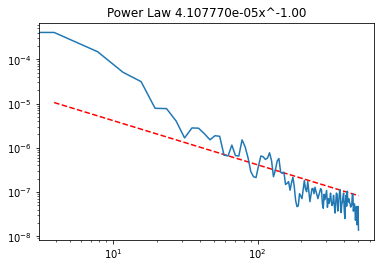

In [11]:
plt.loglog(pink_freq, power_law(pink_freq, *popt), 'r--')
plt.loglog(pink_freq, pink_psd)
plt.title("Power Law {:e}x^{:.2f}".format(popt[0], popt[1]))

From the above plot, it looks like the initial guess is "good enough". 

### An Important Reminder about the Result
**NB:** The best fit curve being shown here is the result of minimizing the residual between the power law function *we defined* and the data. That fact means it's possible to define a different power law, the algorithm does not care.

Remember that the residual is just the normalized difference between values of the function and the data (something like minimizng `PSD-power_law(...)`).

There is nothing invariably correct about this result. This fact is obvious when you consider the above procedure can be repeated for different initial guesses *and some of those results still look "good enough"*.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


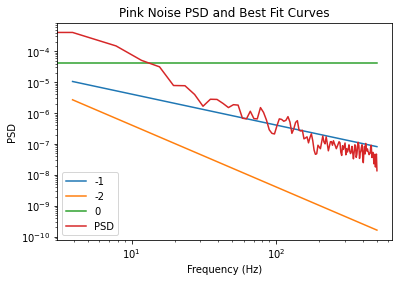

In [12]:
degrees = [-1, -2, 0]
#degrees = [-1]
for degree in degrees:
    #use the chosen degree as an initial guess
    popt, _ = curve_fit(power_law, pink_freq, pink_psd, p0=[pink_psd[0], degree])

    #plot the result
    plt.loglog(pink_freq, power_law(pink_freq, *popt), label=f"{degree}")

plt.loglog(pink_freq, pink_psd, label="PSD")

plt.title("Pink Noise PSD and Best Fit Curves")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.legend(loc='lower left')

plt.show()

## Red Noise, Brownian Noise, Angle Random Walk

Here, we follow the same procedure as in the previous section.

In [13]:
red_noise = make_random_walk(experiment_length=experiment_length, num_steps=num_samples)

In [14]:
red_freq, red_psd = welch(red_noise[1], fs=fs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0.5, 1.0, 'Power Law 5.043173e-04x^-2.00')

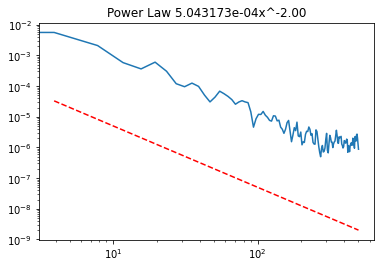

In [15]:
#guess that the power is -2
popt, _ = curve_fit(power_law, red_freq, red_psd, p0=[red_psd[0], -2.0])
plt.loglog(red_freq, power_law(pink_freq, *popt), 'r--')
plt.loglog(red_freq, red_psd)
plt.title("Power Law {:e}x^{:.2f}".format(popt[0], popt[1]))

# Machine Learning Approach

It's preferable to have a program *learn* the degree of best fit curve for the PSD, over a human supplying an initial guess. 

To that end, we can frame our problem as a regression problem. First, a power law $y=Bx^{W}$ looks like a straight line after taking the log of both sides:  

$log(y) = Wlog(x) +log(B) \leftrightarrow Y = WX' + B'$

Then, the goal is to train a model that can learn W and B' from a labeled dataset.

The labeled dataset, in this case, is made up by taking the log of(frequency, PSD amplitude) pairs.

Once the model is trained, its weight and bias parameters give us the exponent (and coefficient) of the power law.

# Generate Data

In [16]:
#(repeat of variables from above for covenience)
experiment_length = 600 #10 minutes
num_samples = 600000 #implies a 1kHz frequency
fs = num_samples/experiment_length

In [17]:
#create a pink noise time series using the experiment parameters above
time, pink_noise = make_bias_drift(experiment_length=experiment_length, num_samples=num_samples)

Text(0, 0.5, 'Noise Amplitude')

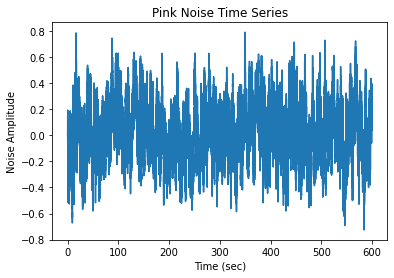

In [18]:
plt.plot(time, pink_noise)

plt.title("Pink Noise Time Series")
plt.xlabel("Time (sec)")
plt.ylabel("Noise Amplitude")

# Calculating the PSD

In [`prototype_welch_psd_function`](https://github.com/nurriol2/learn-imu/blob/main/notebooks/prototype_welch_psd_function.ipynb) we experimented with `signal.welch()` from SciPy. We also coded a power spectral density function from scratch.

In the current notebook, we are going to use the power spectral density we coded from scratch to calculate the PSD of a time series. We're choosing the "homebrew" method over `signal.welch()` because after experimenting with different sampling rates, time series lengths, and function args the "homebrew" method simply works better.

We'll go over what I think are the biggest components contributing to this difference near the end of the current notebook.

In [19]:
from scipy.fft import rfft

def psd(data, dt):
    """Calculate the power spectral density of `data`

    data (numpy.array) - The signal to analyze.
    dt (float) - The inverse sampling frequency (1/fs); Time between data points.
    """

    n = len(data)
    f = data.reshape(-1, )
    fhat = rfft(f, n)
    PSD = np.real(fhat * np.conj(fhat) / n)
    freq = (1/(dt*n)) * np.arange(len(PSD))
    L = np.arange(1, np.floor(n/2), dtype=int)
    return (freq[L], PSD[L])

In [20]:
#calculate the PSD amplitudes over a range of frequencies
freq, pink_psd = psd(pink_noise, 1/fs)

Text(0, 0.5, 'PSD Amplitude')

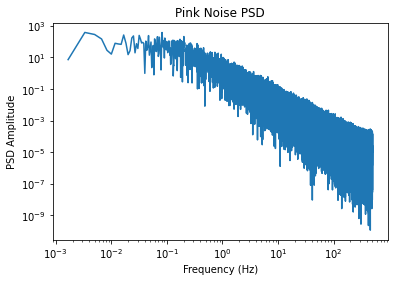

In [21]:
plt.loglog(freq, pink_psd)

plt.title("Pink Noise PSD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD Amplitude")

The above plot is typical of what we would expect for a pink noise time series.

At this point, we would usually plot a reference line and move on.

# Training Data

The PSD above will serve as the training data.

Remember, to frame our problem as a linear regression problem we would need to log-scale the data points. 


In [22]:
#log scaling using homebrew PSD
x_train = np.log(freq.reshape(-1, 1))
y_train = np.log(pink_psd.reshape(-1, 1))

In [23]:
x_train

array([[-6.39692966],
       [-5.70378247],
       [-5.29831737],
       ...,
       [ 6.2145981 ],
       [ 6.21460143],
       [ 6.21460477]])

In [24]:
y_train

array([[  1.98435964],
       [  5.94566046],
       [  5.64756241],
       ...,
       [-10.33988966],
       [-11.02404745],
       [-11.5070456 ]])

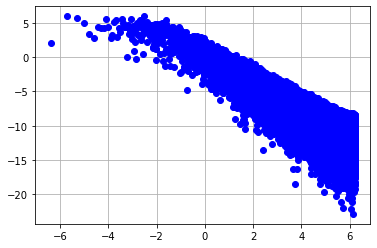

In [25]:
plt.plot(x_train, y_train, "bo")
plt.grid(b=True)

If we were handed the above dataset without context and asked to fit a curve to it, a good guess might be to drop a line right down the center of "the band". 

It's important to note that this view of the dataset is on a linear scale (as seen from the axis labels). **So the units of the axes are incorrect**.

For posterity, it might be best to remove the axis labeling. But for now, we only care about preprocessing for the model.

So, I think at this point the data is prepared. Let's move onto the model.

# Linear Regression Model

In [26]:
import torch
from torch.autograd import Variable

In [27]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

In [28]:
input_size = 1 #number of variables as arguments
output_size = 1 #calculating a single log(y) for a given input
learning_rate = 0.0001
epochs = 200

In [29]:
#define a randomly initialized linear model
model = LinearRegressionModel(input_size, output_size)

In [30]:
#mean squared error is a common loss function for linear regression
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Text(0, 0.5, 'Loss')

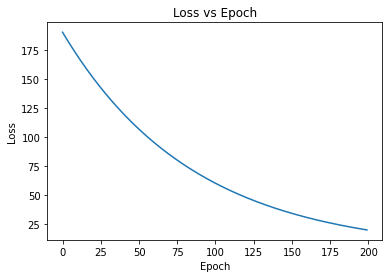

In [31]:
#keep track of loss at each epoch to make a graph later
hist_loss = []

#training 
for epoch in range(epochs):
    inputs = Variable(torch.from_numpy(x_train.astype(np.float32)))
    labels = Variable(torch.from_numpy(y_train.astype(np.float32)))

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    hist_loss.append(loss)
    loss.backward()

    optimizer.step()

    #print(f"Epoch {epoch}\nLoss:  {loss.item()}")

plt.plot(hist_loss)
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

It looks like the model loss decreases steadily over time

In [32]:
#using the train model, make a prediction for the output
with torch.no_grad():
    predicted = model(Variable(torch.from_numpy(x_train.astype(np.float32)))).data.numpy()

The `predicted` values are all log(y) (with respect to our power law variables). 

In [33]:
predicted

array([[ 6.047193 ],
       [ 5.3521075],
       [ 4.9455085],
       ...,
       [-6.599599 ],
       [-6.599602 ],
       [-6.5996056]], dtype=float32)

The learned parameters for our model are the slope and intercept of a line, $Y = WX' + B'$. According to our above equations, that means the parameters are the degree of the power law and a coefficient.

In [34]:
list(model.parameters())

[Parameter containing:
 tensor([[-1.0028]], requires_grad=True), Parameter containing:
 tensor([-0.3676], requires_grad=True)]

In [35]:
slope, intercept = model.parameters()
slope = slope.detach().numpy().item()
intercept = intercept.detach().numpy().item()

In [36]:
slope

-1.0027961730957031

The model predicts that the slope of the line (and therefore the degree of the power law) is about -1!

This is the expected result for a pink noise PSD (pink noise $\rightarrow f^{-1}$). 

In [37]:
intercept

-0.3676237463951111

In [38]:
#figuring out a good domain to plot the model over
print(f"X TRAIN MIN: {x_train.min()}\nX TRAIN MAX:  {x_train.max()}")

X TRAIN MIN: -6.396929655216146
X TRAIN MAX:  6.214604765083303


In [39]:
def line(x, W, B):
    return W*x+B

In [40]:
line_domain = np.arange(x_train.min()-1, x_train.max()+1)
yp = line(line_domain, W=slope, B=intercept)

In [41]:
#line with slope = -2
y2 = line(line_domain, W=-2, B=intercept)

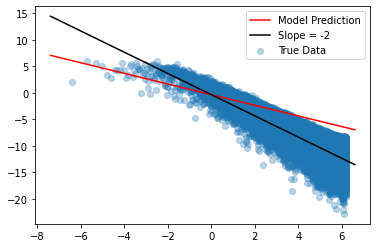

In [42]:
plt.plot(line_domain, yp, "r-", label="Model Prediction")
plt.plot(line_domain, y2, "k-", label="Slope = -2")
plt.scatter(x_train, y_train, label="True Data", alpha=0.3)

plt.legend(loc="upper right")

The model prediction is plotted above on top of the original data. Another line, `y2` is plotted. The line `y2` has slope exactly equal to -2.

So which does a better job of fitting the data?

The model predicts some of the earlier points better than `y2`, but `y2` "splits" the wide band. For that exact reason, I think many humans would say `y2` fits the data better. The tradeoff, however, is that `y2` is clearly not as good a predictor of low frequency points.

# Why `signal.welch()` was not used

The power of machine learning lies in its abilities to give us humans new insights. If the goal with our machine learning approach was to predict values in the dataset, I think the answer to "which model is better" lies within the context of the application. Are the high frequency values (bigger x-values) physically possible in the wild? Do we care about those values? Is a linear model even appropriate?

In the context of *this* application, the predicted model is sucessful over the intuited one (`y2`). The model predicts a slope (power law degree) of -1 for a distribution that we know beforehand follows a slope of -1.

How does this result compare to generating the data using `signal.welch()`?

## Generating PSD from SciPy

Text(0, 0.5, 'PSD Amplitude')

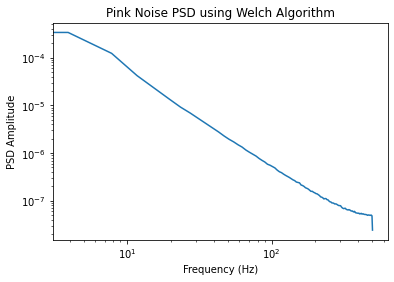

In [43]:
freq, pink_psd = welch(pink_noise, fs=fs)

plt.loglog(freq, pink_psd)
plt.title("Pink Noise PSD using Welch Algorithm")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD Amplitude")

Now we overlay this plot and the "homebrew"

Text(0, 0.5, 'PSD Amplitude')

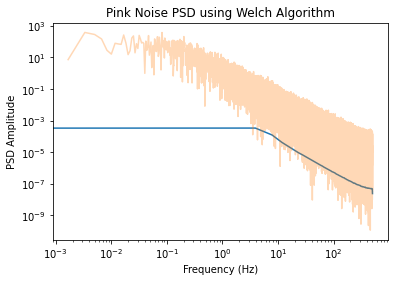

In [44]:
plt.loglog(freq, pink_psd, label="Welch")
plt.loglog(np.exp(x_train), np.exp(y_train), label="Homebrew PSD", alpha=0.3)
plt.title("Pink Noise PSD using Welch Algorithm")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD Amplitude")

The overall shape of the resulting PSD is the same. An obvious differene is, when using the Welch algorithm, the PSD amplitudes are constant instead of varying around a constant.

At the higher frequencies, we see the two plots follow the same trend/downward slope. As a result, I think using SciPy to generate PSD data will result in a linear model with slope closer to -2.

In [45]:
x_train = np.log(freq[1:].astype(np.float32))
y_train = np.log(pink_psd[1:].astype(np.float32))

In [46]:
x_train = np.reshape(x_train, (-1, 1))
y_train = np.reshape(y_train, (-1, 1))

In [47]:
x_train.shape, y_train.shape

((128, 1), (128, 1))

Clearly, the model is working with a lot less data than before. `signal.welch()` seems to always output 129 values (we are dropping 0th to avoid a divide by 0 error) in an array. Even varying sampling frequency and data length did not change this size. 

There might be a way to change this, but for now we will not go into it.

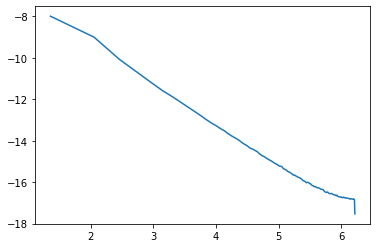

In [48]:
plt.plot(x_train, y_train)

In [49]:
input_size = 1 #number of variables as arguments
output_size = 1 #calculating a single log(y) for a given input
learning_rate = 0.001
epochs = 50

In [50]:
#define a randomly initialized linear model
welch_model = LinearRegressionModel(input_size, output_size)

In [51]:
#mean squared error is a common loss function for linear regression
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(welch_model.parameters(), lr=learning_rate)

Text(0, 0.5, 'Loss')

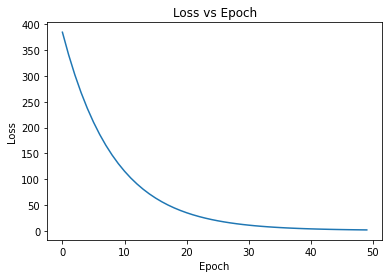

In [52]:
#keep track of loss at each epoch to make a graph later
hist_loss = []

#training 
for epoch in range(epochs):
    inputs = Variable(torch.from_numpy(x_train))
    labels = Variable(torch.from_numpy(y_train))

    optimizer.zero_grad()

    outputs = welch_model(inputs)

    loss = criterion(outputs, labels)
    hist_loss.append(loss)
    loss.backward()

    optimizer.step()

    #print(f"Epoch {epoch}\nLoss:  {loss.item()}")

plt.plot(hist_loss)
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [53]:
#using the train model, make a prediction for the output
with torch.no_grad():
    predicted = welch_model(Variable(torch.from_numpy(x_train.astype(np.float32)))).data.numpy()

In [54]:
list(welch_model.parameters())

[Parameter containing:
 tensor([[-2.5653]], requires_grad=True), Parameter containing:
 tensor([-0.9378], requires_grad=True)]

In [55]:
welch_slope, welch_intercept = welch_model.parameters()
welch_slope = welch_slope.detach().numpy().item()
welch_intercept = welch_intercept.detach().numpy().item()

In [56]:
welch_slope

-2.5652668476104736

As predicted, when `signal.welch()` is used, the predicted power law exponent is about -2.

In [57]:
line_domain = np.arange(x_train.min()-1, x_train.max()+1)
yp = line(line_domain, W=welch_slope, B=welch_intercept)

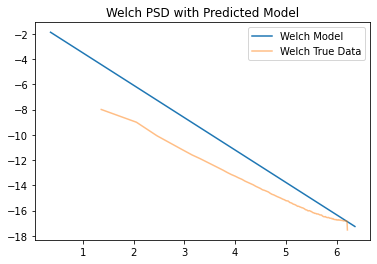

In [58]:
plt.plot(line_domain, yp, label="Welch Model")
plt.plot(x_train, y_train, label="Welch True Data", alpha=0.5)

plt.title("Welch PSD with Predicted Model")
plt.legend(loc="upper right")

The next step is to repeat this process with another color of noise

# Red Noise or Brownian Motion

At the start of this notebook, we defined a function for generating a random walk time series. From the literature, we know that the PSD for a random walk falls off like $1/f^{2}$. So, we hypothesize that a linear regression model learns the slope of a best fit line as -2.

In [59]:
#(repeat of variables from above for covenience)
experiment_length = 600 #10 minutes
num_samples = 600000 #implies a 1kHz frequency
fs = num_samples/experiment_length

In [60]:
#create a red noise time series
time, red_noise = make_random_walk(experiment_length=experiment_length, num_steps=num_samples)

Text(0, 0.5, 'Noise Amplitude')

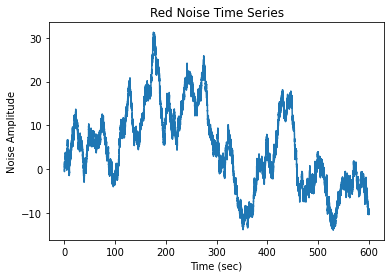

In [61]:
plt.plot(time, red_noise)

plt.title("Red Noise Time Series")
plt.xlabel("Time (sec)")
plt.ylabel("Noise Amplitude")

Text(0, 0.5, 'Noise Amplitude')

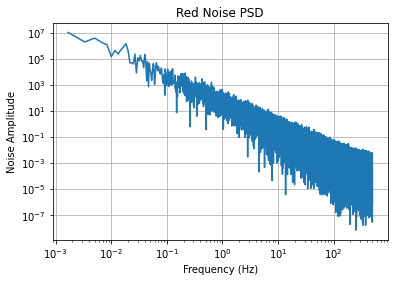

In [62]:
#calculate PSD of red noise
freq, red_psd = psd(red_noise, 1/fs)

plt.loglog(freq, red_psd)

plt.title("Red Noise PSD")
plt.grid(b=True)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Noise Amplitude")

In [63]:
#log scale the data and plot on a linear scale
x_train = np.reshape(np.log(freq).astype(np.float32), (-1, 1))
y_train = np.reshape(np.log(red_psd).astype(np.float32), (-1, 1))

x_train.shape, y_train.shape

((299999, 1), (299999, 1))

SLOPE:  -1.0503557920455933
INETERCEPT: -0.7414522767066956


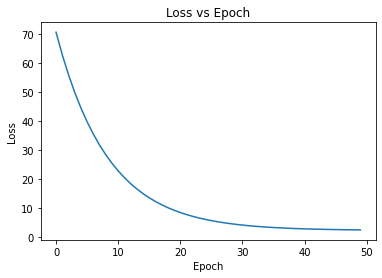

In [64]:
#create a linear regression model
red_model = LinearRegressionModel(1, 1)

learning_rate = 0.001
epochs = 50

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(red_model.parameters(), lr=learning_rate)

#keep track of loss at each epoch to make a graph later
hist_loss = []

#training 
for epoch in range(epochs):
    inputs = Variable(torch.from_numpy(x_train))
    labels = Variable(torch.from_numpy(y_train))

    optimizer.zero_grad()

    outputs = red_model(inputs)

    loss = criterion(outputs, labels)
    hist_loss.append(loss)
    loss.backward()

    optimizer.step()


plt.plot(hist_loss)
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

#using the train model, make a prediction for the output
with torch.no_grad():
    predicted = red_model(Variable(torch.from_numpy(x_train.astype(np.float32)))).data.numpy()

slope, intercept = red_model.parameters()
slope = slope.detach().numpy().item()
intercept = intercept.detach().numpy().item()

print(f"SLOPE:  {slope}\nINETERCEPT: {intercept}")

Text(0.5, 1.0, 'Red Noise PSD and Predicted Model')

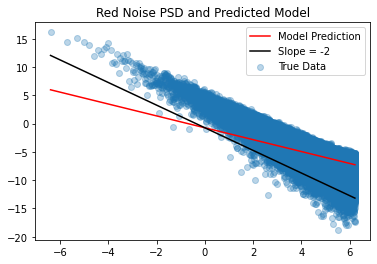

In [65]:
d = np.linspace(x_train.min(), x_train.max())
yr = line(d, slope, intercept)
yr2 = line(d, -2, intercept)

plt.plot(d, yr, "r-", label="Model Prediction")
plt.plot(d, yr2, "k-", label="Slope = -2")
plt.scatter(x_train, y_train, label="True Data", alpha=0.3)

plt.legend(loc="upper right")
plt.title("Red Noise PSD and Predicted Model")

The results of this example look like the reverse of the previous one. Using the same process as before, the learned slope results in a best fit line that predicts high frequency points well, but does not do so well on the low frequency points.

The second line has the same intercept as the predicted model, but a slope of -2. This second line does a better job at "following the lower edge" of the data. Below, we vary the intercept of this line (without altering the slope) as a way of seeing examples of similar behavior. 

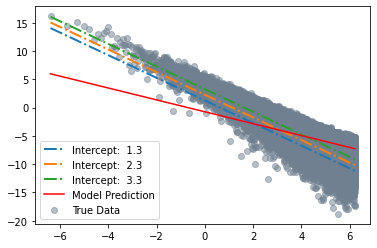

In [66]:
d = np.linspace(x_train.min(), x_train.max())
vary_intercepts = [intercept+e for e in range(2, 5)]
for e in vary_intercepts:
    y2_temp = line(d, -2, e)
    plt.plot(d, y2_temp, "-.", lw=2, label="Intercept:  {:.2}".format(e))

plt.plot(d, yr, "r-", label="Model Prediction")
plt.scatter(x_train, y_train, color="slategray", label="True Data", alpha=0.5)

plt.legend(loc="lower left")

# Conclusion

Overall, I think these examples demonstrate a potential solution to determining the shape of PSD plots. But, the execution needs more work.

Some ideas might be to filter the training data such that there is a uniform number of samples in each frequency band. Then, I think the predicted line would not have to trade off between predicting high/low frequency points better or worse than the other end.

Another, possibly strange idea, might be to do some kind of shortest path between the two ends of the distribution. Then, fit a straight line to the visited points. 

Finally, it might be worth augmenting this entire process with *autocorrelation* plots.

Continuing to verify noise generation with human participation is still necessary, but I think doing these examples is better than blindly trusting the results.